In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.utils import resample
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from sklearn import svm
from sklearn.metrics import classification_report
import pickle

In [2]:
# Initializing the path of the working directory
base_dir = r"C:\Users\MSI\Documents\MiniProject"

# Mapping the image id with their path so that it can be referred easily
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_dir, 'sample', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Reffering to the medadata having the information about all the images we have.
skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# Creating New Columns path , cell_type and cell_type_idx for better readability

# Keeping the path of the respected image
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

# Keeping the human understable Name with the respected name
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

# Keeping the index of the cell_type of the dict
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [4]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [5]:
#Showing the content of the records
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,C:\Users\MSI\Documents\MiniProject\sample\ISIC...,Benign keratosis-like lesions,2


In [6]:
# Preprocessing
# # Checking the records again to see,is there is any record having empty field
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
# Above we find that there are 57 records whose age attribute have null value
# So in this step we are filling that empty fields with the mean value of the attribute age
skin_df['age'].fillna((skin_df['age'].mean()) , inplace = True)

In [8]:
# Checking the records again to see,is there is any record having empty field
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
dataset          0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
# Balancing the dataset
cell_type_idx = 'cell_type_idx'
record_0 = skin_df[skin_df[cell_type_idx] == 0]
record_1 = skin_df[skin_df[cell_type_idx] == 1]
record_2 = skin_df[skin_df[cell_type_idx] == 2]
record_3 = skin_df[skin_df[cell_type_idx] == 3]
record_4 = skin_df[skin_df[cell_type_idx] == 4]
record_5 = skin_df[skin_df[cell_type_idx] == 5]
record_6 = skin_df[skin_df[cell_type_idx] == 6]

In [10]:
n = 500
record_bal_0 = resample(record_0 , replace = True , n_samples = n , random_state = 42)
record_bal_1 = resample(record_1 , replace = True , n_samples = n , random_state = 42)
record_bal_2 = resample(record_2 , replace = True , n_samples = n , random_state = 42)
record_bal_3 = resample(record_3 , replace = True , n_samples = n , random_state = 42)
record_bal_4 = resample(record_4 , replace = True , n_samples = n , random_state = 42)
record_bal_5 = resample(record_5 , replace = True , n_samples = n , random_state = 42)
record_bal_6 = resample(record_6 , replace = True , n_samples = n , random_state = 42)

In [11]:
balance_record = pd.concat([record_bal_0 , record_bal_1 , record_bal_2 , record_bal_3 , record_bal_4 , record_bal_5 , record_bal_6])

In [12]:
balance_record['image'] = balance_record['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))).flatten())

In [13]:
balance_record.shape

(3500, 12)

In [14]:
balance_record.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
dataset           object
path              object
cell_type         object
cell_type_idx       int8
image             object
dtype: object

In [15]:
X = np.asarray(balance_record['image'].tolist())
X.shape

(3500, 12288)

In [16]:
Y = balance_record['cell_type_idx']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=42)

In [18]:
classifier = svm.SVC(kernel='poly' , gamma='auto' , C=1 , probability=True)
classifier.fit(x_train , y_train)
y_predict = classifier.predict(x_test)

In [19]:
print(classification_report(y_test , y_predict))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       126
           1       0.79      0.72      0.76       105
           2       0.61      0.72      0.66        95
           3       0.86      1.00      0.93       101
           4       0.71      0.74      0.72        87
           5       0.76      0.53      0.62        89
           6       0.93      0.96      0.94        97

    accuracy                           0.78       700
   macro avg       0.78      0.78      0.77       700
weighted avg       0.78      0.78      0.78       700



In [20]:
pickle.dump(classifier, open("svm.pkl", "wb"))

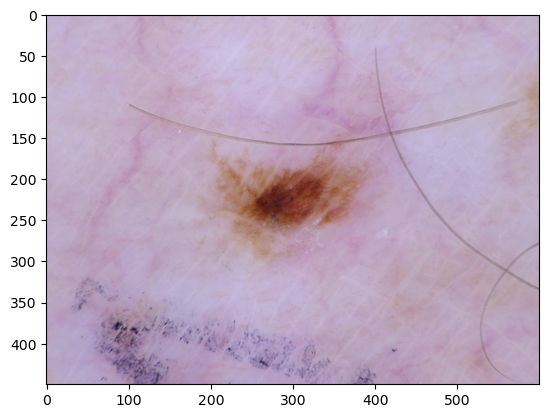

[[0.0153681  0.03469952 0.33517849 0.00460684 0.15988469 0.44518955
  0.00507282]]


In [21]:
url=r"C:\Users\MSI\Documents\MiniProject/sample/ISIC_0024314.jpg"
img=plt.imread(url)
plt.imshow(img)
plt.show()
img_resize=resize(img,(64,64,3))
l=[img_resize.flatten()]
probability=classifier.predict_proba(l)
print(probability)

In [22]:
lesion_type = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]

probability = list(probability.round(2).flatten())
acc = max(probability)
print(
    lesion_type[probability.index(acc)], acc 
)

Vascular lesions 0.45
